# Проект "Промышленность"

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Импорт и настройки

In [1]:
!pip install lightgbm

In [2]:
!pip install catboost

In [3]:
!pip install shap

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from IPython.display import display

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error as mae

pd.set_option('mode.chained_assignment', None)
RANDOM_STATE = 170723
TEST_SIZE = .25

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Загрузка датасетов

In [5]:
links = ['/datasets/data_arc_new.csv',
         '/datasets/data_bulk_new.csv',
         '/datasets/data_bulk_time_new.csv',
         '/datasets/data_gas_new.csv',
         '/datasets/data_temp_new.csv',
         '/datasets/data_wire_new.csv',
         '/datasets/data_wire_time_new.csv']
dfs = {}

for link in links:
    name = link.split('data_')[1].split('_new')[0]
    try:
        dfs[name] = pd.read_csv(link)
        print('Загружен датасет', name)
    except:
        print('Data source unreachable')

Загружен датасет arc
Загружен датасет bulk
Загружен датасет bulk_time
Загружен датасет gas
Загружен датасет temp
Загружен датасет wire
Загружен датасет wire_time


## Обзор

In [6]:
def info(df, len = 3):
    df.info()
    display(df.head(len))
    display(df.tail(len))

### Датасет arc

In [7]:
info(dfs['arc'], 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14870,3240,2019-09-06 16:21:54,2019-09-06 16:24:15,1.202454,0.846936
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


In [8]:
dfs['arc'][['Активная мощность','Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284


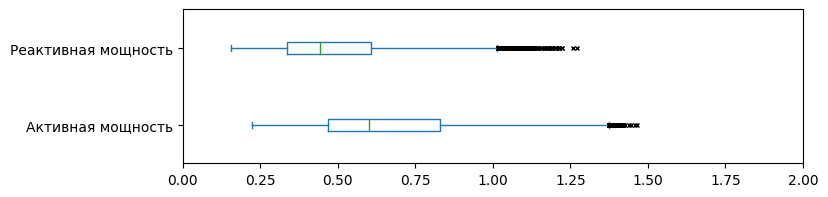

In [9]:
dfs['arc'][['Активная мощность','Реактивная мощность']].plot(kind='box', xlim=(0, 2), vert=False, figsize=(8, 2), flierprops={'marker': 'x', 'markersize': 3});

Датасет содержит информацию о нагреваниях стали. Каждый ковш подогревают несколько раз. Содержится индормация о времени нагревания и затраченных мощностях: активной и реактивной. Количество выбросов небольшое. Аномалий в активной мощности нет, в реактивной есть одно аномальное значение.

### Датасет bulk

In [10]:
info(dfs['bulk'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [11]:
dfs['bulk'].iloc[: , 1:].describe().style.format('{:.1f}')

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.0,22.0,1298.0,1014.0,77.0,576.0,25.0,1.0,19.0,176.0,177.0,2450.0,18.0,2806.0,2248.0
mean,39.2,253.0,113.9,104.4,107.0,118.9,305.6,49.0,76.3,83.3,76.8,260.5,181.1,170.3,160.5
std,18.3,21.2,75.5,48.2,81.8,72.1,191.0,nan,21.7,26.1,59.7,120.6,46.1,65.9,51.8
min,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
25%,27.0,242.0,58.0,72.0,70.0,69.8,155.0,49.0,66.0,64.0,25.0,204.0,153.2,119.0,105.0
50%,31.0,251.5,97.5,102.0,86.0,100.0,298.0,49.0,68.0,86.5,64.0,208.0,155.5,151.0,160.0
75%,46.0,257.8,152.0,133.0,132.0,157.0,406.0,49.0,70.5,102.0,106.0,316.0,203.5,205.8,205.0
max,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


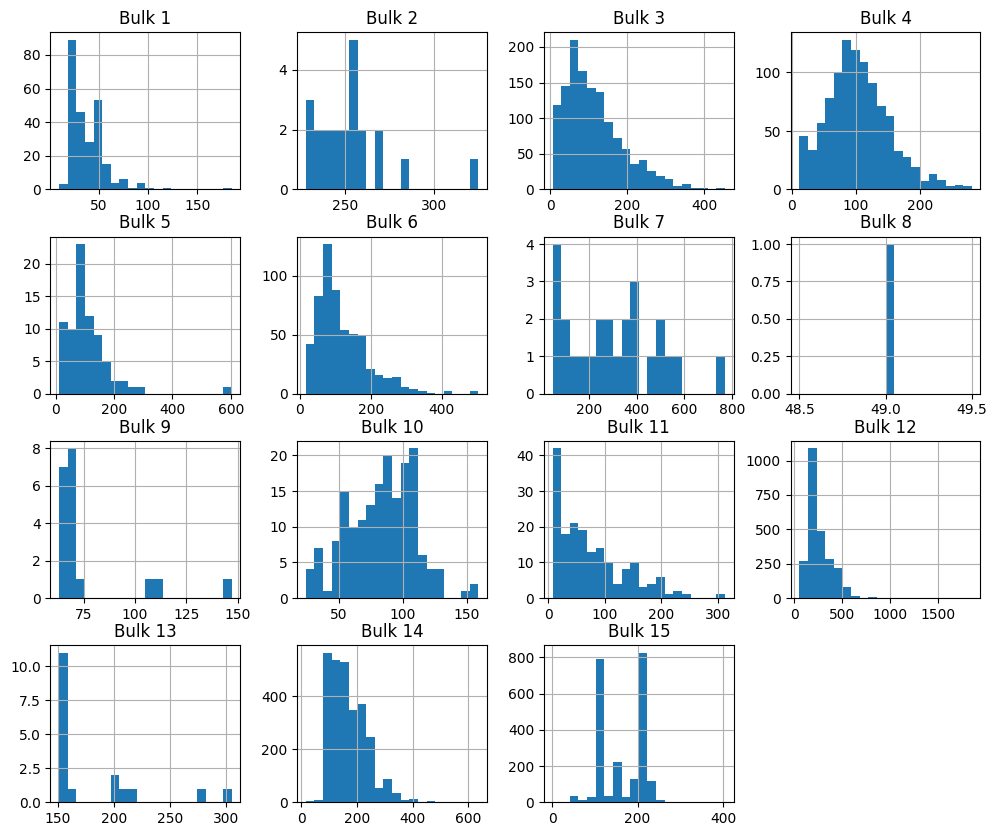

In [12]:
dfs['bulk'].iloc[: , 1:].hist(bins=20, figsize=(12, 10));

Датасет содержит информацию о количестве добавленных сыпучих материалов. Большая часть записей пропущена, что говорит о том, что материалы не добавлялись. Аномальных значений не выялено.

### Датасет bulk_time

In [13]:
info(dfs['bulk_time'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


Датасет содержит информацию о времени когда подавались сыпучие материалы.

### Датасет gas

In [14]:
info(dfs['gas'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


,key,Газ 1
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [15]:
dfs['gas']['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

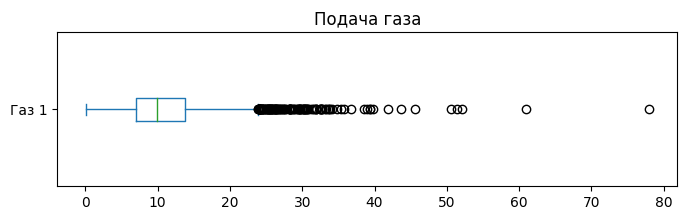

In [16]:
dfs['gas']['Газ 1'].plot(kind='box', figsize=(8, 2), title='Подача газа', vert=False);

Датасет содержит информацию о количестве газа которое использовалось для продувки ковша. Пропусков нет, количество выбросов небольшое, аномальных значений не выялено.

### Датасет temp

In [17]:
info(dfs['temp'], 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


,key,Время замера,Температура
18086,3241,2019-09-06 16:48:55,1586.0
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


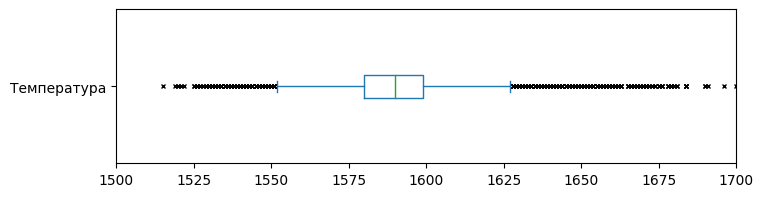

In [18]:
dfs['temp']['Температура'].plot(kind='box', xlim=(1500, 1700), vert=False, figsize=(8, 2), flierprops={'marker': 'x', 'markersize': 3});

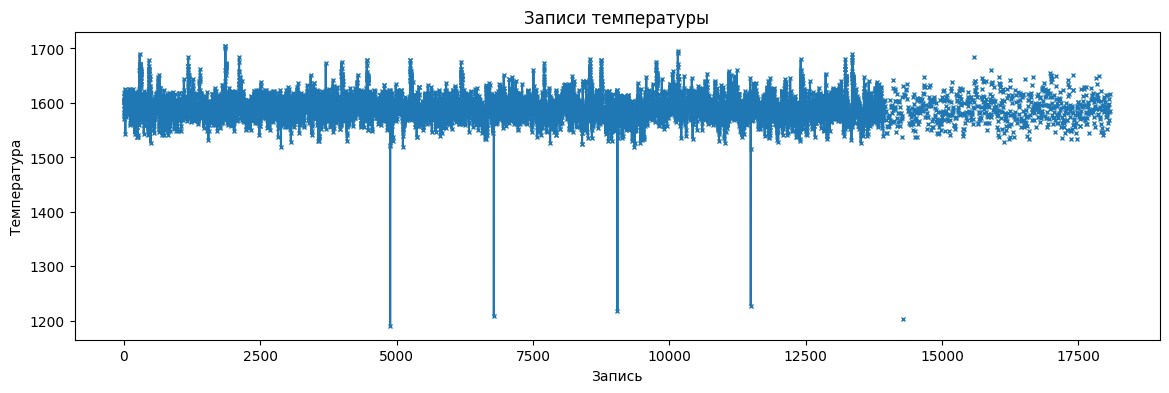

In [19]:
dfs['temp']['Температура'].plot(style='x-', ms=3, figsize=(14, 4), title='Записи температуры', ylabel='Температура', xlabel='Запись');

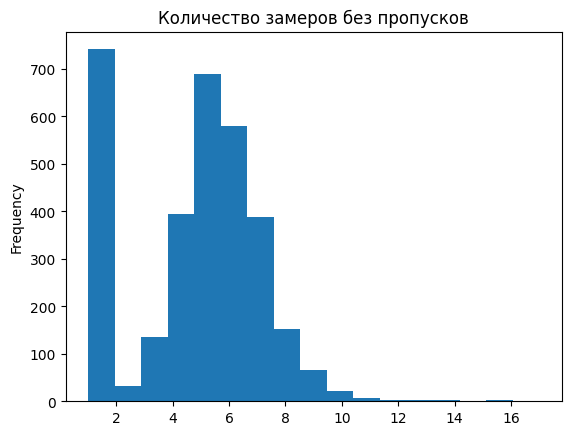

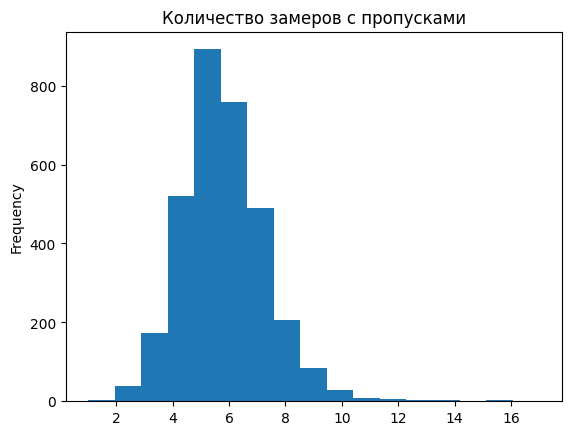

In [20]:
t = dfs['temp'].pivot_table(index='key', values='Температура', aggfunc='count')
t.plot(kind='hist', bins=t['Температура'].max(), title='Количество замеров без пропусков', legend=False);
t = dfs['temp'].fillna(0).pivot_table(index='key', values='Температура', aggfunc='count')
t.plot(kind='hist', bins=t['Температура'].max(), title='Количество замеров с пропусками', legend=False);

Датасет содержит информацию о температуре расплава в ковше в разные моменты времени. Встречаются несколько аномальных значений и большое количество пропусков в последней четверти датасета.

### Датасет wire

In [21]:
info(dfs['wire'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


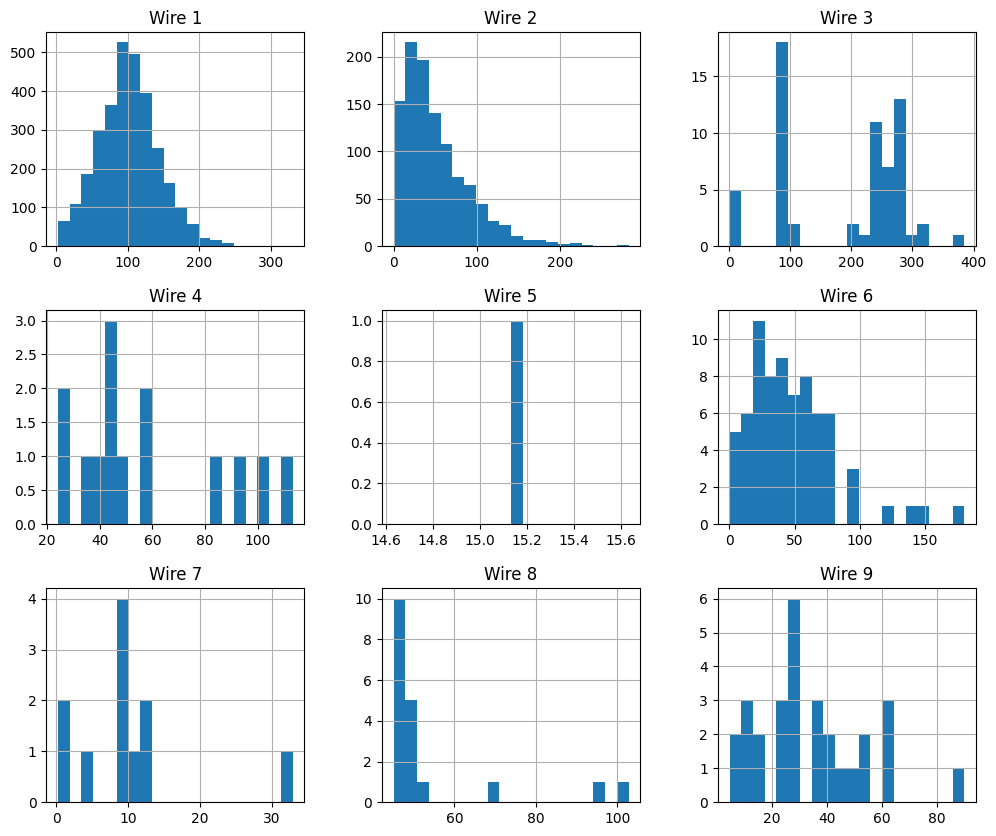

In [22]:
dfs['wire'].iloc[: , 1:].hist(bins=20, figsize=(12, 10));

In [23]:
dfs['wire'].iloc[: , 1:].describe().style.format('{:.1f}')

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.0,1079.0,63.0,14.0,1.0,73.0,11.0,19.0,29.0
mean,100.9,50.6,189.5,57.4,15.1,48.0,10.0,53.6,34.2
std,42.0,39.3,99.5,28.8,nan,33.9,8.6,16.9,19.9
min,1.9,0.0,0.1,24.1,15.1,0.0,0.2,45.1,4.6
25%,72.1,20.2,95.1,40.8,15.1,25.1,6.8,46.1,22.1
50%,100.2,40.1,235.2,45.2,15.1,42.1,9.0,46.3,30.1
75%,126.1,70.2,276.3,76.1,15.1,64.2,11.9,48.1,43.9
max,330.3,282.8,385.0,113.2,15.1,180.5,32.8,102.8,90.1


Датасет содержит информацию о подаче проволочных материалов. Большая часть датасета содержит пропуски, что говорит о том, что материалы не подавались. Аномальных значений не выялено.

### Датасет wire_time

In [24]:
info(dfs['wire_time'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет содержит информацию о времени подачи прополочных материалаов.

### Вывод

Для предсказания температуры расплава нам необходимо учитывать начальную температуру, скорость и время нагревания, скорость рассеивания тепла и время через которое нужно предсказать температуру.

Данные которые могут быть нам полезны:

*   Активная мощность и время из датасета arc
*   Количество добавленных сыпучих материалов из датасета bulk
*   Количество добавленных проволочных материалов из датасета wire
*   Количество газа из датасета gas
*   Температура и время замера из датасета temp

Остальные данные не помогут в предсказании температуры.

## План работ

Предполагаю, что масса расплава будет незначительно зависеть от добавок материалов, так как соотношение массы добавок к массе расплава невелико и остывание от продувки газа также небольшое, то температура в основном будет зависеть в основном от мощности затраченной на нагревание и прошедьшим временем.   

Значения температуры имеют критическое значение для предсказания, поэтому придется удалить все ключи где они есть. Также можно будет удалить ключи с аномалиями, так как их немного.

1.   Определится с используемыми для предсказания признаками.
1.   Убрать аномальные данные и создать объединенный датасет с признаками и таргетом.
1.   Проверить признаки на мультиколлинеарность и удалить избыточные.
1.   Разделим полученный датасет на тренировочную, тестовую выборки.
1.   Сделаем подбор гиперпараметров для различных моделей.
1.   Оценим лучшую модель на тестовой выборке.



## Подготовка датасета

### Датасет temp

Начнем с датасета temp. Сделаем сводную таблицу в которой будут записаны первые и последние записи по ключу. Здесь же заполним пропуски, чтобы можно было позже удалить пропущенные значения.

In [25]:
df = dfs['temp'].fillna(0).pivot_table(index='key', aggfunc=['first', 'last'])
df.columns = ['time_first', 'temp_first', 'time_last', 'temp_last']

Сразу удаляем аномальные значения и пропуски, это будут температуры ниже 1400.

In [26]:
df = df[(df['temp_first'] > 1400) & (df['temp_last'] > 1400)]
df.describe()

,temp_first,temp_last
count,2473.000000,2473.000000
mean,1589.016175,1595.338051
std,24.996127,16.031388
min,1519.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


Поменяем тип данных для времени и запишем разницу времен.

In [27]:
df[['time_first', 'time_last']] = df[['time_first', 'time_last']].apply(pd.to_datetime)
df['time_delta'] = (df['time_last'] - df['time_first']).dt.total_seconds()

Удаляем записи с нулевым временем, так как такие записи явно не соответствуют реальному техпроцессу.

In [28]:
df = df[df['time_delta'] > 0]
df.describe()

,temp_first,temp_last,time_delta
count,2471.000000,2471.000000,2471.000000
mean,1589.012950,1595.339943,2281.317685
std,25.004369,16.035215,1374.343709
min,1519.000000,1541.000000,339.000000
25%,1572.000000,1587.000000,1544.500000
50%,1588.000000,1593.000000,2007.000000
75%,1605.000000,1599.000000,2739.500000
max,1679.000000,1700.000000,23674.000000


### Датасет arc

Далее подготовим датасет arc. Сохраним во временную переменную записи которые остались в df.

In [29]:
temp_df = dfs['arc'][dfs['arc']['key'].isin(df.index)]

Поменяем тип данных для колонок времени и создадим колонку с разницей.

In [30]:
temp_df[['Начало нагрева дугой', 'Конец нагрева дугой']] = temp_df[['Начало нагрева дугой', 'Конец нагрева дугой']].apply(pd.to_datetime)
temp_df['time_delta_heat'] = (temp_df['Конец нагрева дугой'] - temp_df['Начало нагрева дугой']).dt.total_seconds()

Реактивная мощность не учавствует в выделении тепла, поэтому мы ее не учитываем. Создаем сводную таблицу с суммами активной мощностей и времен, и запишем ее в итоговую таблицу и сразу посмотрим какие там значения.

In [31]:
df[['time_delta_heat', 'active_power']] = temp_df.pivot_table(index='key', values=['time_delta_heat', 'Активная мощность'], aggfunc='sum')
df[['time_delta_heat', 'active_power']].describe()

,time_delta_heat,active_power
count,2471.000000,2471.000000
mean,800.304330,3.078472
std,340.783792,1.220758
min,57.000000,0.267676
25%,573.000000,2.246892
50%,773.000000,2.995221
75%,987.000000,3.776895
max,4189.000000,12.375636


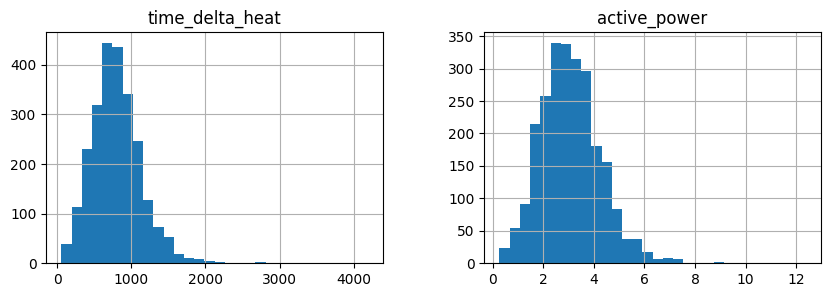

In [32]:
df[['time_delta_heat', 'active_power']].hist(bins=30, figsize=(10, 3));

Минимальное время нагрева минута, а максимальное больше часа. Без подробной информации о деталях производства сложно сделать вывод о правдоподобности таких данных, поэтому оставим все значения.

### Датасет bulk

Переходим к датасету bulk. Проверим сколько ключей совпадает и сколько нет.

In [33]:
df.index.isin(dfs['bulk']['key']).sum(), (~df.index.isin(dfs['bulk']['key'])).sum()

(2403, 68)

Количество несовпадений не слишком большое, и чтобы не искажать данные, не будем заполнять пропуски, а уберем их.

Заполним все пропуски нулем и сделаем внутреннее объединение с итоговым датасетом по ключу.

В обзоре мы уже видели, что аномально высоких значений нет, поэтому дополнительно удалять что либо не будем.

In [34]:
df = df.join(dfs['bulk'].fillna(0).set_index('key'), how='inner')

### Датасет wire

Переходим к датасету wire. Проверим сколько ключей совпадает и сколько нет.

In [35]:
df.index.isin(dfs['wire']['key']).sum(), (~df.index.isin(dfs['wire']['key'])).sum()

(2327, 76)

Количество несовпадений также не слишком большое, также уберем их при помощи объединения.

Аномально высоких значений также нет.

In [36]:
df = df.join(dfs['wire'].fillna(0).set_index('key'), how='inner')

### Датасет gas

Переходим к датасету gas. Проверим сколько ключей совпадает и сколько нет.

In [37]:
df.index.isin(dfs['gas']['key']).sum(), (~df.index.isin(dfs['gas']['key'])).sum()

(2325, 2)

Здесь почти все хорошо, поэтому также объединяем.

Аномально высоких значений нет.

In [38]:
df = df.join(dfs['gas'].fillna(0).set_index('key'), how='inner')

### Проверка мультиколлинеарности

Удалим ненужные столбцы.

In [39]:
df = df.drop(['time_first', 'time_last'], axis=1)

Отобразим тепловую карту корреляций.

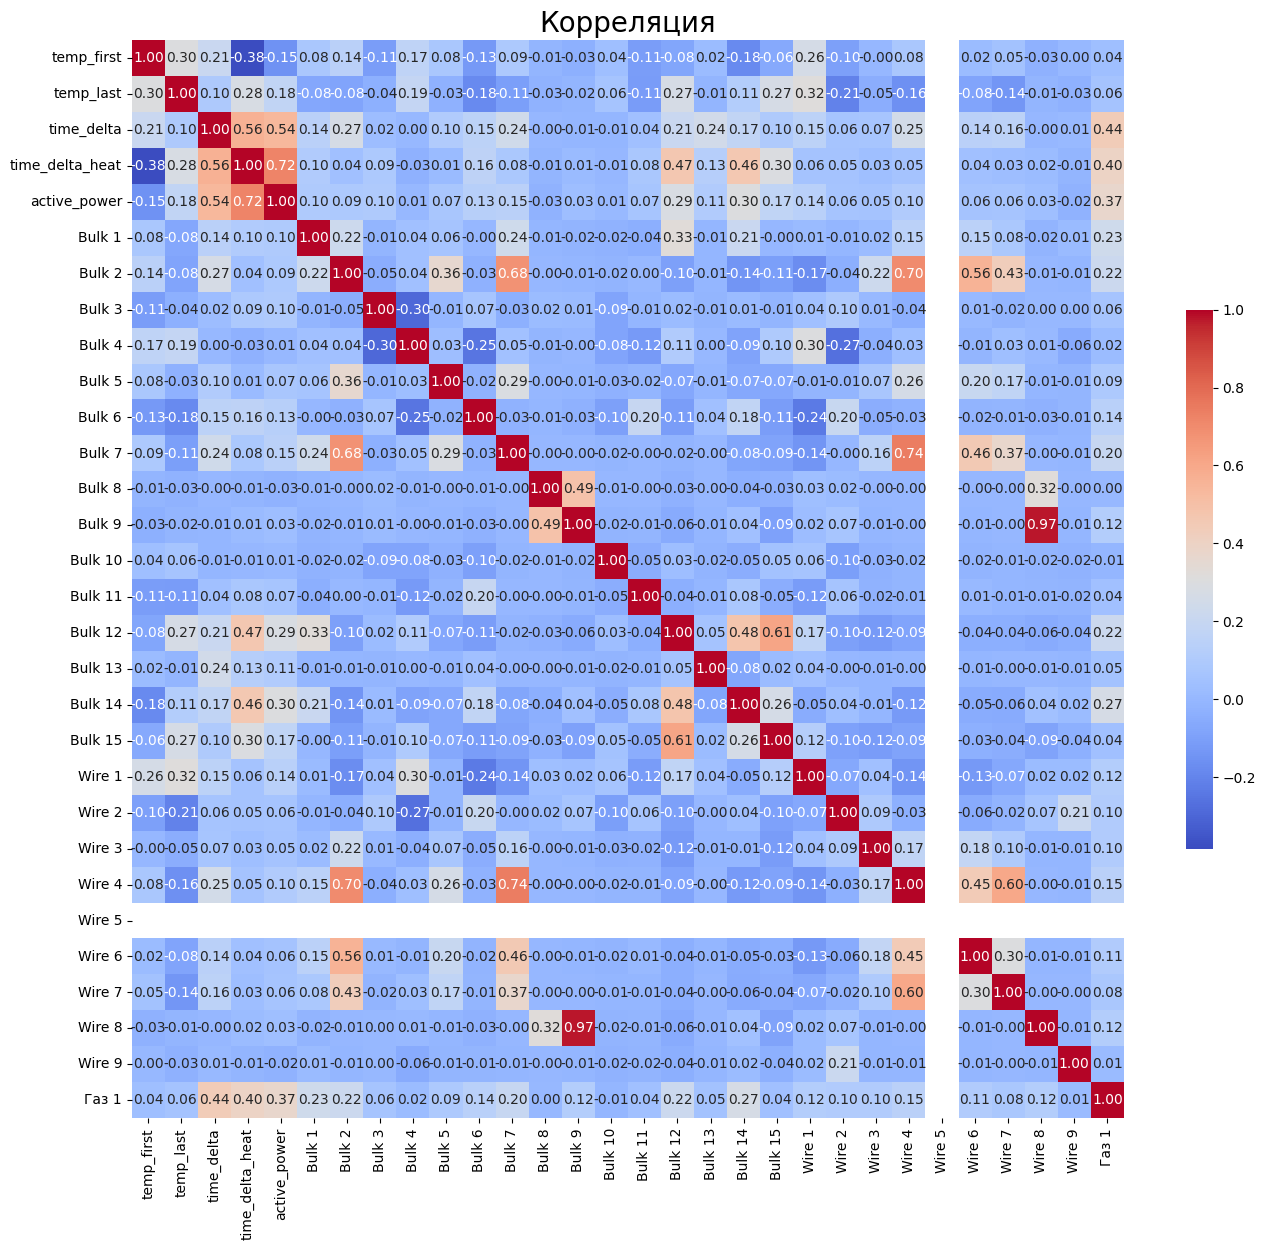

In [40]:
plt.figure(figsize = (16,14))
ax = sns.heatmap(df.corr(), cmap="coolwarm", fmt='.2f', annot=True, cbar_kws={'shrink': .5});
plt.title('Корреляция', fontsize = 20)
plt.show()

Очень выражена корреляция wire 8 и bulk 9, а также у wire 5 только одно значение. Удалим wire 8, так как у него корреляция с temp_last чуть ниже, и wire 5, так как там все равно нет данных.

In [41]:
df = df.drop(['Wire 5', 'Wire 8'], axis=1)

### Создание выборок

Создаем features и target.

In [42]:
features = df.drop(['temp_last'], axis=1)
target = df['temp_last']

Создадим выборки

In [43]:
X_train, X_test, y_train, y_test = tts(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1743, 27), (582, 27), (1743,), (582,))

Отмасштабируем признаки для линейной модели.

In [44]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

## Обучение моделей

### Linear Regression

In [45]:
model_lr = LinearRegression()
lr_MAE = abs(cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')).mean()
print(f'MAE LinearRegression {lr_MAE:.2f}')

MAE LinearRegression 6.06


### LightGBM

In [46]:
param_lgbm = {
    'random_state':[RANDOM_STATE],
    'learning_rate': [0.01, 0.05],
    'reg_alpha': [4, 8],
    'reg_lambda': [1, 2],
    'objective':['regression'],
    'force_col_wise': ['true'],
    'verbose':[-1]
}

model_lgbm = LGBMRegressor()

grid_cv_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_lgbm, cv=5, scoring='neg_mean_absolute_error')
grid_cv_lgbm.fit(X_train, y_train)
lgbm_params = grid_cv_lgbm.best_params_
lgbm_MAE = abs(grid_cv_lgbm.best_score_)
print(f'Гиперпараметры LightGBM {lgbm_params}\nMAE LightGBM {lgbm_MAE:.2f}')

Гиперпараметры LightGBM {'force_col_wise': 'true', 'learning_rate': 0.05, 'objective': 'regression', 'random_state': 170723, 'reg_alpha': 8, 'reg_lambda': 2, 'verbose': -1}
MAE LightGBM 5.94


### CatBoostRegressor

In [47]:
param_catboost = {
    'random_state':[RANDOM_STATE],
    'iterations': [500],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [2, 3],
    'eval_metric': ['MAE'],
    'verbose':[False]
}

model_catboost = CatBoostRegressor()

grid_cv_catboost = GridSearchCV(estimator=model_catboost, param_grid=param_catboost, cv=5, scoring='neg_mean_absolute_error', verbose=1)
grid_cv_catboost.fit(X_train, y_train)
catboost_MAE = abs(grid_cv_catboost.best_score_)
catboost_params = grid_cv_catboost.best_params_
print(f'Гиперпараметры CatBoost {catboost_params}\nMAE CatBoost {catboost_MAE:.2f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Гиперпараметры CatBoost {'eval_metric': 'MAE', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'random_state': 170723, 'verbose': False}
MAE CatBoost 5.89


### Подытог

Результаты обучения:
* MAE LinearRegression 6.06
* MAE LGBMRegressor 5.94
* MAE CatBoostRegressor 5.89



CatBoostRegressor показала себя лучше остальных.

### Тестирование лучшей модели

In [48]:
model_catboost = CatBoostRegressor(**catboost_params)
model_catboost.fit(X_train, y_train)
print(f'Тестовая MAE CatBoostRegressor {mae(y_test, model_catboost.predict(X_test)):.2f}')

Тестовая MAE CatBoostRegressor 5.53


Значения MAE на тестовой выборке удовлетворяет условиям.

### Оценка влияния признаков

Используем SHAP для оценки влияния признаков.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


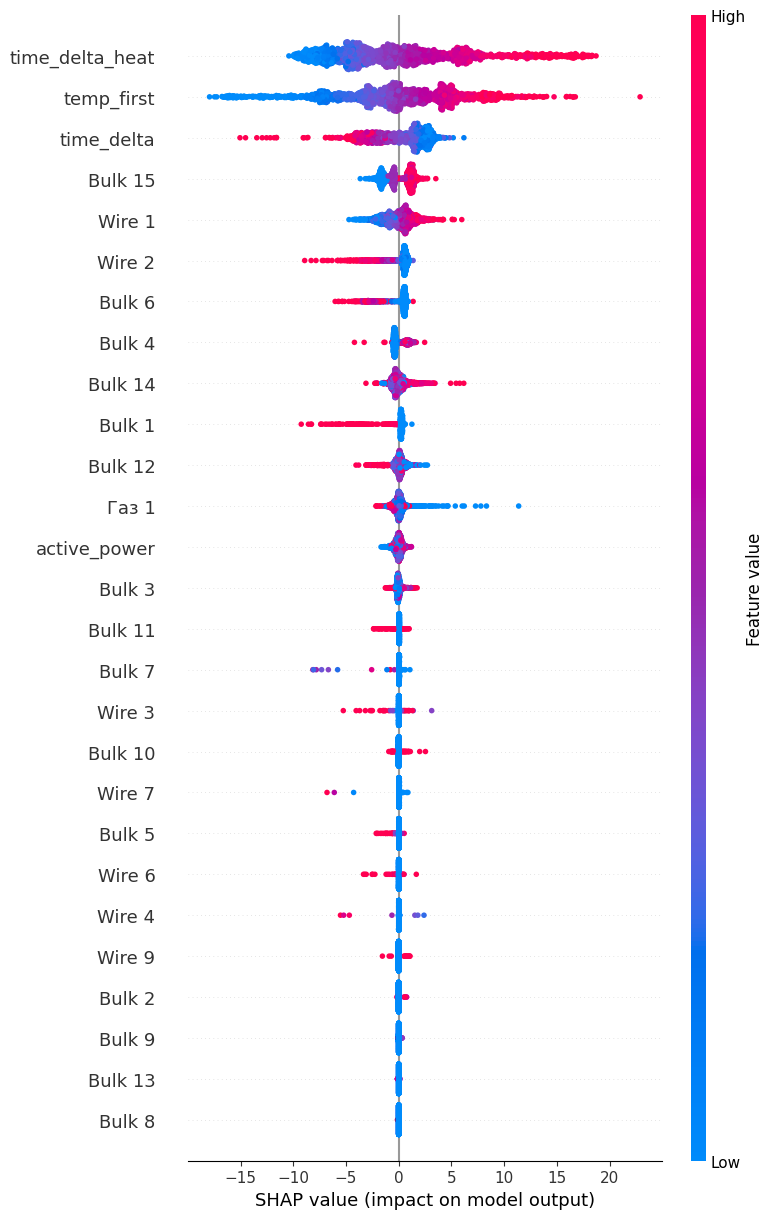

In [49]:
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1])

Наибольшее значение имеет время нагрева, причем затраченная мощность оказывет малое влияние, зависимость прямая.

Начальная температура также имеет прямую зависимость от конечной.

Зависимость от времени нахождения расплава в ковше обратная.

Зависимость подачи материала из bulk 15 и wire 1 также обратная.

Подача большого количества материала из wire 2, bulk 6, 1, 12 снижает итоговую температуру.

Подача малого количества газа оказывает положительное влияние на температуру.

Остальные признаки оказывают небольшое влияние.

#### Проверка модели

In [50]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
print(f'Тестовая MAE DummyRegressor {mae(y_test, dummy.predict(X_test)):.2f}')

Тестовая MAE DummyRegressor 8.19


Медианная модель показывает большую метрику. Модель проходит проверку.

## Итоги работы

Для данной задачи ключевыми шагами были: разобраться в исходных данных и техпроцессе, выбор значимых для целевого признака данных, их обработка и подготовка, обучение различных моделей с подбором гиперпараметров, тестирование лучшей модели и оценка влияния признаков в полученной модели.

Для обучения модели были использованы следующие признаки:
* Начальная температура
* Время работы с ковшом
* Суммарная затраченная активная мощность
* Суммарное время нагрева
* Добавки сыпучих и проволочных материалов
* Продувка газом

В результате предобработки были удалены аномальные и пропущенные значения температуры, а также нулевое время работы с ковшом. Удален один из двух линейно зависимых признаков с коэффициентом корреляции 0.97, а также признак с нулевыми значениями. Дополнительно для линейной модели было сделано масштабирование признаков.

Итоговой моделью стала CatBoostRegressor с метрикой MAE 5.89 на кросс-валидации и MAE 5.53 на тестовой выборке.   
Ее гиперпараметры:
* eval_metric MAE
* iterations 500
* l2_leaf_reg 3
* learning_rate 0.05
* random_state 170723


Для улучшения качества модели рекомендую собрать больше статистических данных, а также собрать дополнительные данные об техпроцессе от чего может зависеть начальная температура расплава, время подогрева и время работы с ковшом, так как это самые существенные признаки влияющие на конечную температуру.

Все пункты плана были успешно выполнены. В ходе работы были выделены признаки из различных датасетов, создан объединенный датасет с нужными признаками, удалены аномальные значения, произведена проверка на мультиколлинеарность признаков, удален линейно зависимый признак и нулевой.

Для данной задачи ключевыми шагами были: разобраться в исходных данных и техпроцессе, выбор значимых для целевого признака данных, их обработка и подготовка, обучение различных моделей с подбором гиперпараметров, тестирование лучшей модели и оценка влияния признаков в полученной модели.

Для обучения модели были использованы следующие признаки:
* Начальная температура
* Время работы с ковшом
* Суммарная затраченная активная мощность
* Суммарное время нагрева
* Добавки сыпучих и проволочных материалов
* Продувка газом

В результате предобработки были удалены аномальные и пропущенные значения температуры, а также нулевое время работы с ковшом. Удален один из двух линейно зависимых признаков с коэффициентом корреляции 0.97, а также признак с нулевыми значениями. Дополнительно для линейной модели было сделано масштабирование признаков.

Итоговой моделью стала CatBoostRegressor с метрикой MAE 5.89 на кросс-валидации и MAE 5.53 на тестовой выборке.   
Ее гиперпараметры:
* eval_metric MAE
* iterations 500
* l2_leaf_reg 3
* learning_rate 0.05
* random_state 170723


Для улучшения качества модели рекомендую собрать больше статистических данных, а также собрать дополнительные данные об техпроцессе от чего может зависеть начальная температура расплава, время подогрева и время работы с ковшом, так как это самые существенные признаки влияющие на конечную температуру.